In [ ]:
pip install tensorflow keras opencv-python numpy dlib

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model():
    model = Sequential()

    # Convolutional layers to extract features
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the 3D features to 1D
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))  # 7 classes for emotions

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
 import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/fer2013.csv')

# Preprocess the data
X = []
y = []
for index, row in data.iterrows():
    try:
        X.append(np.array(row['pixels'].split(), dtype='float32').reshape(48, 48, 1))
    except ValueError:
        # Print the problematic row and skip it
        print(f"Error processing row {index}: {row}")
        continue  # Skip to the next row
    y.append(row['emotion'])

X = np.array(X) / 255.0  # Normalize pixel values
y = to_categorical(np.array(y), num_classes=7)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = create_model()
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=64)

# Save the model
model.save('emotion_detection_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 320s 706ms/step - accuracy: 0.2676 - loss: 1.7739 - val_accuracy: 0.4281 - val_loss: 1.4968
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 321s 705ms/step - accuracy: 0.4427 - loss: 1.4502 - val_accuracy: 0.4936 - val_loss: 1.3365
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 320s 701ms/step - accuracy: 0.5061 - loss: 1.3014 - val_accuracy: 0.5231 - val_loss: 1.2629
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 320s 696ms/step - accuracy: 0.5403 - loss: 1.2178 - val_accuracy: 0.5400 - val_loss: 1.2024
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 324s 700ms/step - accuracy: 0.5725 - loss: 1.1301 - val_accuracy: 0.5549 - val_loss: 1.1688
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 319s 693ms/step - accuracy: 0.5996 - loss: 1.0641 - val_accuracy: 0.5617 - val_loss: 1.1537
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 325s 701ms/step - accuracy: 0.6197 - loss: 1.0079 - val_accuracy: 0.5736 - val_loss: 1.1629
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 321s 697ms/step - accuracy: 0.6542 -

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('emotion_detection_model.h5')


In [ ]:
from google.colab.patches import cv2_imshow

<IPython.core.display.Javascript object>

Saved to photo.jpg


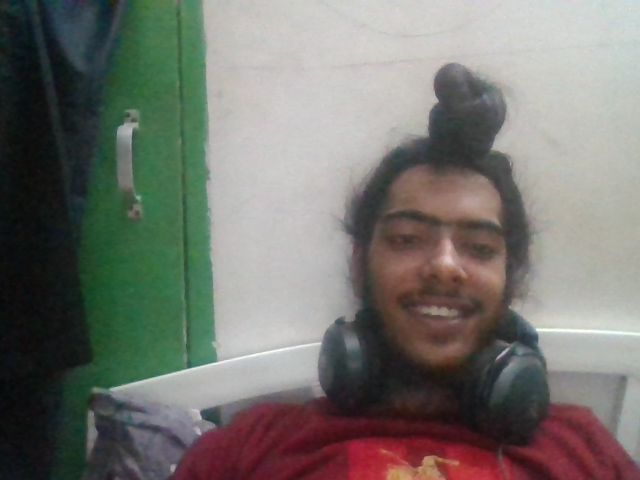

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import PIL.Image
import io
import numpy as np
import base64

# JavaScript code to capture photo
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📷 Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize video to match aspect ratio
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for user to click
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

# Capture photo
filename = take_photo()
print(f"Saved to {filename}")

# Load image for OpenCV
image = cv2.imread(filename)
cv2_imshow(image)  # If you want to display it in Colab


🧠 Predicted Emotion: Happy


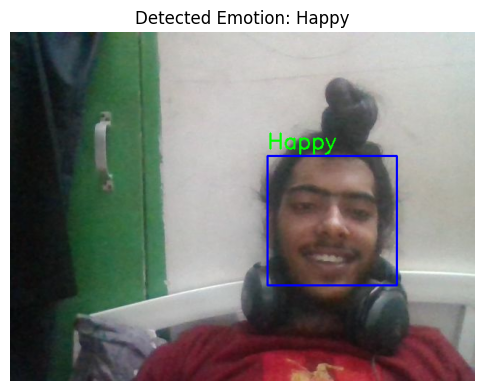

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt

# Load model
model = load_model('/content/emotion_detection_model.h5')  # make sure path is correct

# Load face detector
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Load the captured image
image_path = '/content/photo.jpg'  # change if different
frame = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_classifier.detectMultiScale(gray, 1.3, 5)

# Process each detected face
for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

    if np.sum([roi_gray]) != 0:
        roi = roi_gray.astype('float') / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        prediction = model.predict(roi, verbose=0)[0]
        label = emotion_labels[prediction.argmax()]
        print(f"🧠 Predicted Emotion: {label}")

        cv2.putText(frame, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Display result
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Emotion: {label}")
plt.show()
